# Imports & Constants

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import statsmodels.api as sm

from scipy import stats
from matplotlib.colors import ListedColormap

In [4]:
from jupyter_utils import mean_std, display_test, display_group_test, show_corrtest_mask_corr

In [5]:
import warnings
warnings.filterwarnings(action='ignore', category=np.VisibleDeprecationWarning)
warnings.filterwarnings(action='ignore', message='All-NaN slice encountered')
warnings.filterwarnings(action='ignore', message='Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.')

In [6]:
sns.set_theme(style="whitegrid")

In [7]:
PATH = '/Users/galina.ryazanskaya/Downloads/thesis?/code?/transcripts_NET/'

In [8]:
PATH_FIG = '/Users/galina.ryazanskaya/Downloads/thesis?/figures/de/'

# Load & clean patient data

total positve ftd - saps34 <br>
total alogia - sans12 <br>
sex_nr - female = 1, male = 0 <br>
ausja_bl = education years at baseline (i.e. 6 months before the NET interview) <br>
pa - panss <br>

### calculate total psychiatric scores and fill NA

In [9]:
# load psychiatric data for the participants
df = pd.read_excel(PATH +'NAP/GR_all6M_MPP.xlsx', index_col=0, na_values=[' ', '', -99.0])
df = df[df.index.notnull()].drop(columns=['Unnamed: 98', 'Unnamed: 99'])

In [10]:
df['panss_pos'] = df[['pa_0' + str(i) for i in range(1, 8)]].sum(axis=1)
df['panss_neg'] = df[['pa_' + ('0' + str(i) if i< 10 else str(i)) for i in range(8, 16)]].sum(axis=1)
df['panss_o'] = df[['pa_' + str(i) for i in range(16, 31)]].sum(axis=1)
df['panss_total'] = df[['panss_pos', 'panss_neg', 'panss_o']].sum(axis=1)
df['saps_total'] = df[[c for c in df.columns if c.startswith('saps')]].sum(axis=1)
df['sans_total'] =  df[[c for c in df.columns if c.startswith('sans')]].sum(axis=1)

### Filter out only the patients there are transcripts for

In [11]:
df.index.rename('ID', inplace=True)

In [12]:
# load scores for the transcripts (patients)
res = pd.read_csv('/Users/galina.ryazanskaya/Downloads/thesis?/code?/processed_values/de_patients.tsv', sep='\t', index_col=0, header=[0, 1, 2])

In [13]:
res.dropna(how='all', inplace=True)

In [14]:
# bring IDs from results and psychiatric scores to a uniform standard
idxs = sorted([x.replace('_6M_manual_c', '') for x in res.index])
idxs = ['MPP_0' + i if len(i) > 1 else 'MPP_00' + i for i in idxs]

In [15]:
res.index = ['MPP_0' + i if len(i) > 1 else 'MPP_00' + i for i in [x.replace('_6M_manual_c', '') for x in res.index]]
res.index.rename('ID', inplace=True)

In [16]:
assert not set(idxs).difference(set(df.index))

In [17]:
df = df.loc[idxs]

### Explore descriptive statistics

In [18]:
clinical_cols = ['age', 'sex_nr', 'Bildungsjahre', 'IQ_kristallin', 
                'saps34', 'saps_total', 'sans_total', 'sans12', 
                'panss_pos', 'panss_neg', 'panss_o', 'panss_total']

In [19]:
scale_cols = ['saps_total',
             'sans_total',
             'panss_pos',
             'panss_neg',
             'panss_o',
             'panss_total']

In [20]:
mean_std(df, clinical_cols)

,age,sex_nr,Bildungsjahre,IQ_kristallin,saps34,saps_total,sans_total,sans12,panss_pos,panss_neg,panss_o,panss_total
value,39.49 (11.11),0.41 (0.5),14.62 (2.95),105.16 (15.65),1.03 (1.05),16.81 (16.7),27.73 (20.35),0.92 (1.19),12.66 (5.48),16.85 (6.03),27.75 (7.51),57.26 (16.18)


In [21]:
# grouped by sex
mean_std(df, clinical_cols, 'sex_nr')

,age,sex_nr,Bildungsjahre,IQ_kristallin,saps34,saps_total,sans_total,sans12,panss_pos,panss_neg,panss_o,panss_total
sex_nr,,,,,,,,,,,,
0.0,37.29 (10.12),0.0 (0.0),14.54 (3.11),107.0 (12.7),1.03 (1.04),18.57 (16.7),28.63 (21.23),0.94 (1.24),13.37 (5.61),17.14 (6.6),28.64 (7.63),59.15 (16.99)
1.0,42.71 (11.9),1.0 (0.0),14.73 (2.78),102.35 (19.28),1.04 (1.08),14.25 (16.71),26.42 (19.37),0.88 (1.15),11.62 (5.22),16.42 (5.17),26.45 (7.3),54.5 (14.84)


In [22]:
df.groupby('sex_nr').count()['age']

sex_nr
0.0    35
1.0    24
Name: age, dtype: int64

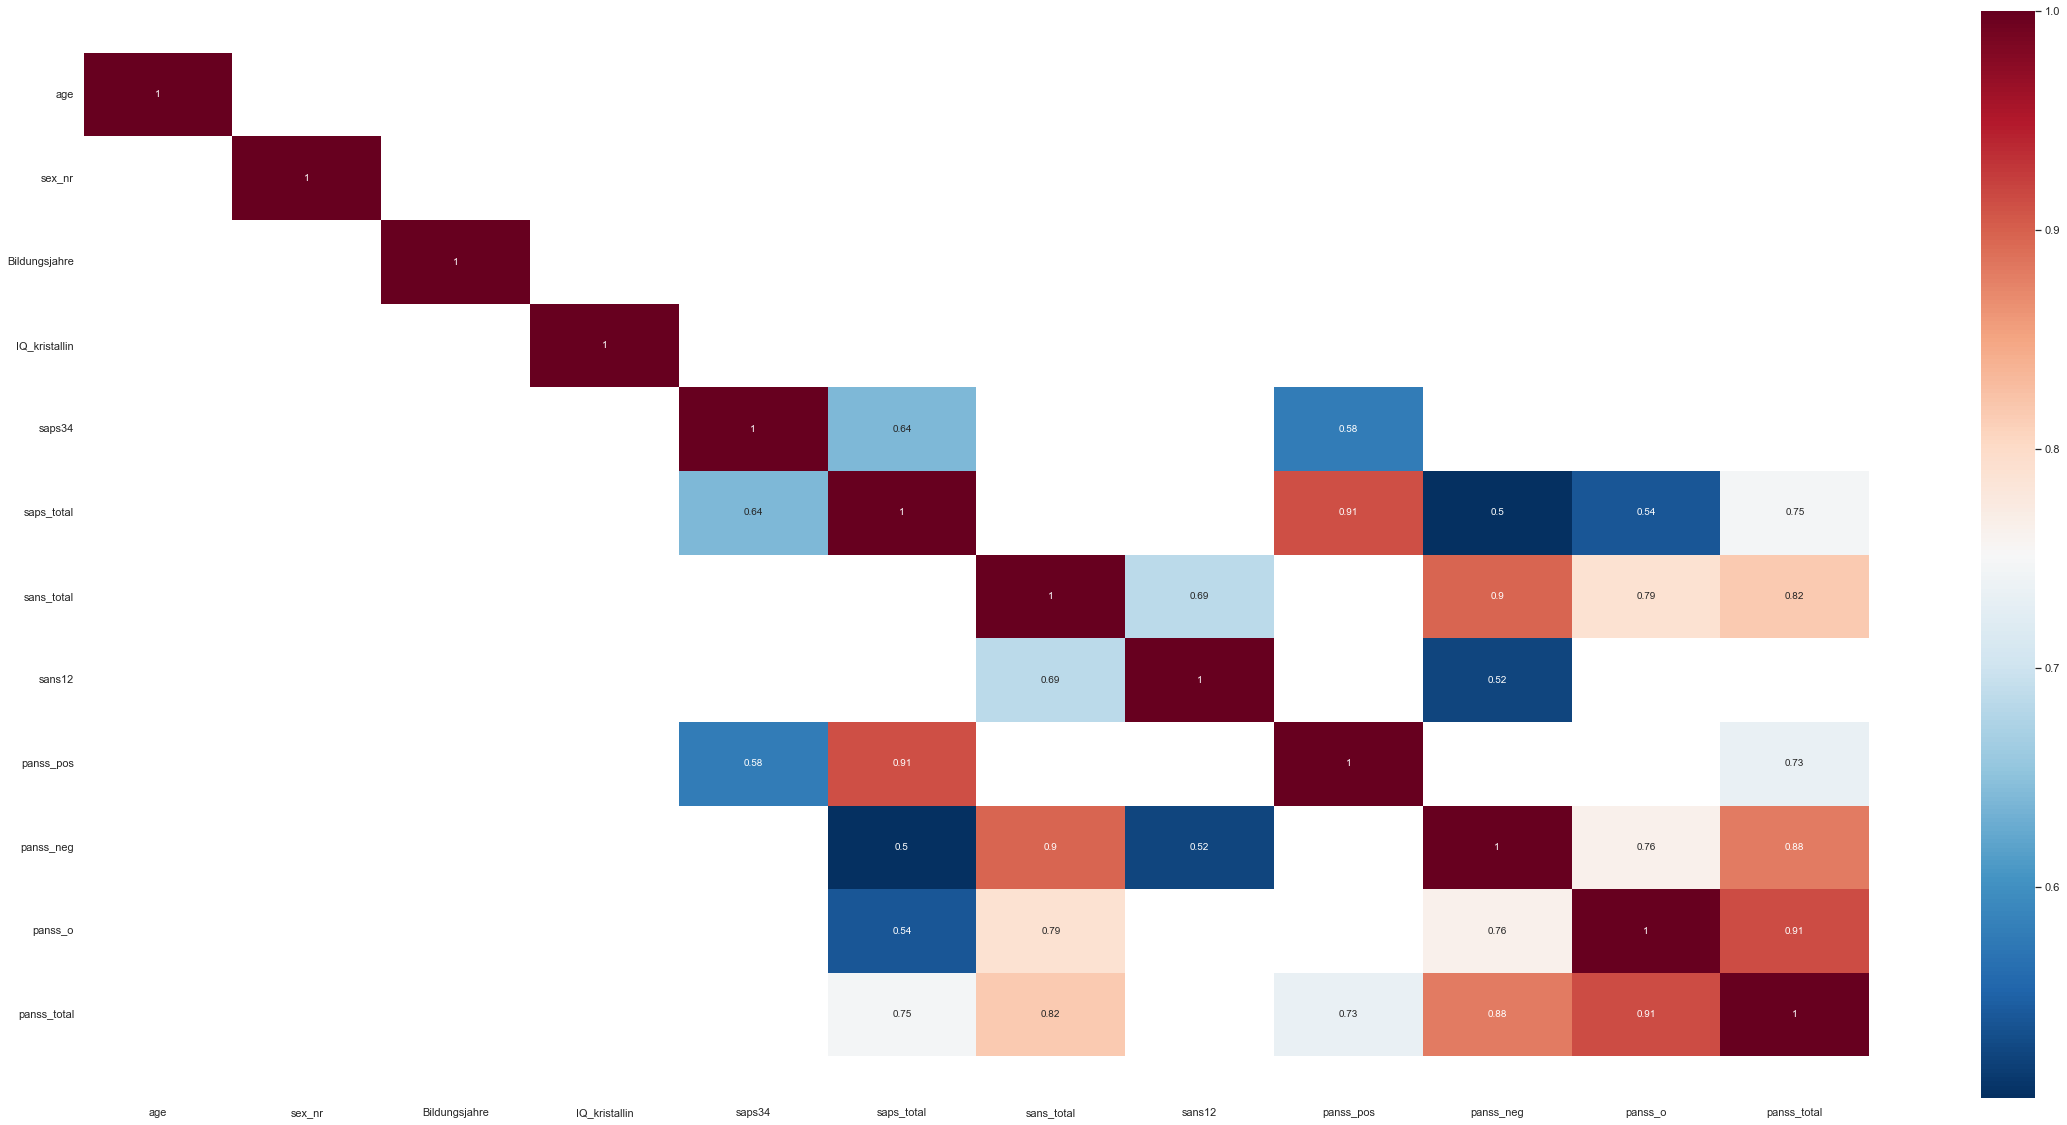

In [23]:
corr = show_corrtest_mask_corr(df[clinical_cols])
## 1. age does not correlate with IQ, education years, or psychiatric scales
## 2. IQ does not correlate with education years or psychiatric scales
## 3. saps-total correlates with saps34 and panss_pos
## 4. sans-total correlates with sans12 and panss_neg, panss_o, panss_total
## 5. panss-total correlates with panss_o, panss_neg, sans-total, panss_pos, saps-total

In [24]:
r = mean_std(df, scale_cols)

In [25]:
r.loc['max'] = pd.Series([170, 120, 49, 49, 112, 210], index=r.columns)
r.loc['min'] = pd.Series([0, 0, 7, 7, 16, 30], index=r.columns)
r.loc['share'] = r.loc['value'].apply(lambda x: float(x.split(' ')[0])) / r.loc['max'] 

In [26]:
r

,saps_total,sans_total,panss_pos,panss_neg,panss_o,panss_total
value,16.81 (16.7),27.73 (20.35),12.66 (5.48),16.85 (6.03),27.75 (7.51),57.26 (16.18)
max,170,120,49,49,112,210
min,0,0,7,7,16,30
share,0.098882,0.231083,0.258367,0.343878,0.247768,0.272667


### Relative symptom severity (positive vs negative symptoms)

In [27]:
fig, axes = plt.subplots(6, 1, figsize=(10, 8))
fig.suptitle('comparison between psychiatric scales')
sns.boxplot(x=df['saps_total'], ax=axes[0], color='tab:orange')
axes[0].set_xlim(0, 120)
axes[0].set_ylabel('saps_total', rotation='horizontal', ha='right')
sns.boxplot(x=df['sans_total'], ax=axes[1])
axes[1].set_xlim(0, 170)
axes[1].set_ylabel('sans_total', rotation='horizontal', ha='right')
sns.boxplot(x=df['panss_pos'], ax=axes[2], color='tab:orange')
axes[2].set_xlim(7, 49)
axes[2].set_ylabel('panss_pos', rotation='horizontal', ha='right')
sns.boxplot(x=df['panss_neg'], ax=axes[3])
axes[3].set_xlim(7, 49)
axes[3].set_ylabel('panss_neg', rotation='horizontal', ha='right')
sns.boxplot(x=df['panss_o'], ax=axes[4], color='grey')
axes[4].set_xlim(16, 112)
axes[4].set_ylabel('panss_o', rotation='horizontal', ha='right')
sns.boxplot(x=df['panss_total'], ax=axes[5], color='grey')
axes[5].set_xlim(30, 210)
axes[5].set_ylabel('panss_total', rotation='horizontal', ha='right')
for ax in axes[:5]:
    ax.set_xlabel('')
axes[5].set_xlabel('score')
fig.tight_layout();
plt.savefig(f'{PATH_FIG}psychiatric.png', dpi=150, bbox_inches = 'tight')
plt.close(fig)

### Load & count diagnostic groups
1 - sz<br>
2 - sza

In [28]:
diagnosis = pd.read_excel('/Users/galina.ryazanskaya/Downloads/thesis?/code?/transcripts_NET/NAP/GR_Diagn.xlsx')
diagnosis['ID'] = diagnosis['Pat.ID']
diagnosis.index = diagnosis['ID']
diagnosis.drop(columns=['ID', 'Pat.ID'], inplace=True)

In [29]:
dia_only = diagnosis.drop(columns=['Messzeitpunkt']).dropna()
dia_only[dia_only['Diagnose_Kategorie'].isin([1, 2])]
dia_only[~dia_only.index.duplicated(keep='first')].value_counts()

Diagnose_Kategorie
1                     97
2                     33
dtype: int64

# Load & clean healthy control data

In [30]:
df_hc = pd.read_csv(PATH + 'HC/NET_HC.csv', index_col=0, na_values=[' ', ''])

### Check that all the transcripts are availble

In [31]:
# load scores for the transcripts (controls)
res_hc =  pd.read_csv('/Users/galina.ryazanskaya/Downloads/thesis?/code?/processed_values/de_HC.tsv', sep='\t', index_col=0, header=[0, 1, 2])

In [32]:
idxs_HC = sorted([x.replace('_c', '').replace('NET_', '')  for x in res_hc.index])

In [33]:
assert not set(idxs_HC).difference(set(df_hc.index))

In [34]:
df_hc = df_hc.loc[idxs_HC]

In [35]:
df_hc.index.rename('ID', inplace=True)

In [36]:
# bring IDs from results and psychiatric scores to a uniform standard
res_hc.index = [x.replace('_c', '').replace('NET_', '')  for x in res_hc.index]
res_hc.index.rename('ID', inplace=True)

### Explore descriptive statistics

In [37]:
mean_std(df_hc, ['age', 'Bildungsjahre'])

,age,Bildungsjahre
value,43.85 (13.29),15.5 (2.78)


In [38]:
# grouped by sex
mean_std(df_hc, ['age', 'Bildungsjahre'], 'sex_nr')

,age,Bildungsjahre
sex_nr,,
0.0,42.27 (12.24),15.7 (3.13)
1.0,45.78 (14.99),15.28 (2.51)


In [39]:
df_hc.groupby('sex_nr').count()

,age,Bildungsjahre
sex_nr,,
0.0,11,10
1.0,9,9


# Fill NA in POS

In [40]:
cols_LM = [col for col in res_hc if col[1] == 'LM']
cols_synt = [col for col in res_hc if col[1] == 'syntactic']
cols_lex = [col for col in res_hc if col[1] == 'lexical']
cols_graph = [col for col in res_hc if col[1] == 'graph']

In [41]:
pos = set([x[1] for x in cols_synt if x[1].isupper()])

In [42]:
POS_to_use = ('ADJ', 'ADV', 'AUX', 'CCONJ', 'DET','NOUN', 'PRON', 'PROPN', 'SCONJ', 'VERB', 'PART')

In [43]:
s = res_hc[cols_synt].isna().any()
res_hc[s[s].index] = res_hc[s[s].index].fillna(0.0)

In [44]:
cols_to_drop = [c for c in cols_synt if c[2].isupper() and c[2] not in POS_to_use]
res_hc.drop(columns=cols_to_drop, inplace=True)

In [45]:
s = res[cols_synt].isna().any()
res[s[s].index] = res[s[s].index].fillna(0.0)

In [46]:
cols_to_drop = [c for c in [col for col in res if col[1] == 'syntactic'] if c[2].isupper() and c[2] not in POS_to_use]
res.drop(columns=cols_to_drop, inplace=True)

In [47]:
cols_synt = [col for col in res_hc if col[1] == 'syntactic']
cols_av = [c for c in res_hc['averaged'].columns if c[0] in ['LM', 'syntactic', 'graph', 'lexical']]

# Merge control and patient data & test for group differences

In [48]:
df['group'] = 1
df_hc['group'] = 0
compare_groups = pd.concat([df[clinical_cols + ['group']], df_hc], axis=0)

In [49]:
compare_groups.groupby(['group']).count()

,age,sex_nr,Bildungsjahre,IQ_kristallin,saps34,saps_total,sans_total,sans12,panss_pos,panss_neg,panss_o,panss_total
group,,,,,,,,,,,,
0,20,20,19,0,0,0,0,0,0,0,0,0
1,59,59,59,58,59,59,59,59,59,59,59,59


In [50]:
mean_std(compare_groups, ['age', 'Bildungsjahre'], 'group')

,age,Bildungsjahre
group,,
0,43.85 (13.29),15.5 (2.78)
1,39.49 (11.11),14.62 (2.95)


In [51]:
# test for difference in age
stats.ttest_ind(df['age'], df_hc['age']).pvalue

0.15339927043476997

In [52]:
# test for difference in education years
stats.ttest_ind(df['Bildungsjahre'], df_hc['Bildungsjahre'], nan_policy='omit').pvalue

0.2552563345667248

In [53]:
combined_data_averaged = compare_groups.merge(pd.concat([res['averaged'], res_hc['averaged']], axis=0), on='ID', how='outer')

/var/folders/1l/2khv4cgj7xs0zrm9hnl_yrzh0000gn/T/ipykernel_3054/1114475667.py:1: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  combined_data_averaged = compare_groups.merge(pd.concat([res['averaged'], res_hc['averaged']], axis=0), on='ID', how='outer')


In [54]:
compare_groups_ = pd.DataFrame()
for col in clinical_cols + ['group']:
    compare_groups_[('target', 'target', col)] = compare_groups[col]

In [55]:
combined_data_all = compare_groups_.merge(pd.concat([res, res_hc], axis=0), on='ID', how='outer')

/var/folders/1l/2khv4cgj7xs0zrm9hnl_yrzh0000gn/T/ipykernel_3054/2330308397.py:1: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 3 on the right)
  combined_data_all = compare_groups_.merge(pd.concat([res, res_hc], axis=0), on='ID', how='outer')


In [56]:
combined_data_all.columns = pd.MultiIndex.from_tuples(combined_data_all.columns)

In [57]:
TASKS = ['averaged', 'anger', 'fear', 'happiness', 'sadness']

In [58]:
def task_data(df, task, keep_target=True, fill_synt=True):
    subset = df[task].dropna(axis=0, how='any')
    if task == 'fear' and 'KG_018' in subset.index:
        subset = subset.drop(['KG_018']) # incorrect task
    if fill_synt:
        subset['syntactic'] = subset['syntactic'].fillna(0.0)
    if keep_target:
        subset = pd.concat([subset, df['target'].loc[subset.index]], axis=1)
    return subset

# Analyze the asscoiations with the control factors

In [59]:
def test_corr_sig(df, cols, target_col, mult=len(TASKS)):
    s, t = display_test(df, cols, target_col, stats.pearsonr, stat_name='r')
    t['p'] = t['p'] * (len(t) * mult)
    t['corr_sig'] = t['p'] < 0.05
    t['p'] = t['p'] / (len(t) * mult)
    t.drop(columns=['sig'], inplace=True)
    return t.sort_values([f'abs_r', 'p'], ascending=False)

In [60]:
tgt_tsk = [('target', c) for c in ('panss_total', 'panss_neg', 'panss_pos', 'panss_o', 'sans_total', 'saps_total', 'age', 'Bildungsjahre')]

In [61]:
# prints only significant relations
for task in TASKS:
    print(task)
    tres = test_corr_sig(task_data(combined_data_all, task), tgt_tsk, ('syntactic', 'mean_sent_len'))
    tr = tres[tres['corr_sig'] == True]
    if len(tr) > 0:
        print(tr)

averaged
                             r         p     abs_r  corr_sig
(target, sans_total) -0.443426  0.000436  0.443426      True
(target, panss_neg)  -0.423542   0.00083  0.423542      True
anger
                             r         p     abs_r  corr_sig
(target, sans_total) -0.488521  0.000087  0.488521      True
(target, panss_neg)  -0.477264  0.000132  0.477264      True
fear
happiness
sadness


In [62]:
for task in TASKS:
    print(task)
    tres = test_corr_sig(task_data(combined_data_all, task), tgt_tsk, ('target', 'age'))
    tr = tres[tres['corr_sig'] == True]
    if len(tr) > 0:
        print(tr)

averaged
anger
fear
happiness
sadness


In [63]:
for task in TASKS:
    print(task)
    tres = test_corr_sig(task_data(combined_data_all, task), tgt_tsk, ('target', 'Bildungsjahre'))
    tr = tres[tres['corr_sig'] == True]
    if len(tr) > 0:
        print(tr)

averaged
anger
fear
happiness
sadness


In [64]:
for task in TASKS:
    print(task)
    tres = test_corr_sig(task_data(combined_data_all, task), tgt_tsk, ('target', 'IQ_kristallin'))
    tr = tres[tres['corr_sig'] == True]
    if len(tr) > 0:
        print(tr)

averaged
anger
fear
happiness
sadness


In [65]:
a=0.05
def t_test_corr_sig(df, cols, target_col, mult=len(TASKS)):
    s, t = display_group_test(df, cols, target_col, stats.ttest_ind, stat_name='t', alpha=a)
    t['p'] = t['p'] * (len(t) * mult)
    t['corr_sig'] = t['p'] < 0.05
    t['p'] = t['p'] / (len(t) * mult)
    t.drop(columns=['sig'], inplace=True)
    return t.sort_values([f'abs_t', 'p'], ascending=False)

In [66]:
for task in TASKS:
    print(task)
    tsk_data = task_data(combined_data_all, task, keep_target=True)
    tsk_cols = [c for c in tsk_data.columns if c[0] != 'target']
    tres = t_test_corr_sig(tsk_data, tsk_cols, ('target', 'sex_nr'))
    tr = tres[tres['corr_sig'] == True]
    if len(tr) > 0:
        print(tr)

averaged
anger
fear
happiness
sadness


### Group difference for sex (absent)

In [67]:
a = 0.001
s_t_sex, res_t_sex = display_group_test(combined_data_averaged, clinical_cols, 'sex_nr', stats.ttest_ind, stat_name='t', alpha=a)
res_t_sex.drop(index=['sex_nr'])['sig'].any()

False

In [68]:
s_t_sex, res_t_sex = display_group_test(combined_data_averaged, cols_av, 'sex_nr', stats.ttest_ind, stat_name='t', alpha=a)
res_t_sex['sig'].any()

False

### Correlative effects for age, education years, and IQ (absent)

In [69]:
x, y = display_test(combined_data_averaged, cols_av, 'age', stats.pearsonr, stat_name='r', alpha=a)
y[y['abs_r']> 0.2].sort_values('abs_r', ascending=False)['sig'].any()

False

In [70]:
x, y = display_test(combined_data_averaged, cols_av, 'Bildungsjahre', stats.pearsonr, stat_name='r', alpha=a)
y[y['abs_r']> 0.3].sort_values('abs_r', ascending=False)['sig'].any()

False

In [71]:
x, y = display_test(combined_data_averaged, cols_av, 'IQ_kristallin', stats.pearsonr, stat_name='r', alpha=a)
y[y['abs_r']> 0.3].sort_values('abs_r', ascending=False)

,r,p,sig,abs_r
"(syntactic, AUX)",0.335383,0.010064,False,0.335383


In [72]:
s, t = display_test(combined_data_averaged, cols_av, 'age', stats.pearsonr, stat_name='r')
t['p'] = t['p'] * (len(t))
t['corr_sig'] = t['p'] < 0.05
t['p'] = t['p'] / (len(t))
t.drop(columns=['sig'], inplace=True)
t['corr_sig'].any()

False

In [73]:
s, t = display_test(combined_data_averaged, cols_av, 'Bildungsjahre', stats.pearsonr, stat_name='r')
t['p'] = t['p'] * (len(t))
t['corr_sig'] = t['p'] < 0.05
t['p'] = t['p'] / (len(t))
t.drop(columns=['sig'], inplace=True)
t['corr_sig'].any()

False

In [74]:
s, t = display_test(combined_data_averaged, cols_av, 'IQ_kristallin', stats.pearsonr, stat_name='r')
t['p'] = t['p'] * (len(t))
t['corr_sig'] = t['p'] < 0.05
t['p'] = t['p'] / (len(t))
t.drop(columns=['sig'], inplace=True)
t['corr_sig'].any()

False

In [75]:
combined_data_averaged.to_csv('/Users/galina.ryazanskaya/Downloads/thesis?/code?/processed_values/de_averaged.csv')

In [76]:
combined_data_all.to_csv('/Users/galina.ryazanskaya/Downloads/thesis?/code?/processed_values/de_all.csv')

# Analyze lengths

In [77]:
def plot_scatter_corr(x, y, x_name, y_name, ax, title=None, c=None, 
                      cmap_colors=('steelblue', 'gold'), 
                      classes=('control', 'NAP'),
                      xlim=None, ylim=None): #'control',
    r = stats.pearsonr(x, y).statistic
    X = sm.add_constant(x)
    model = sm.OLS(y, X).fit()
    ypred = model.predict(X)
    if xlim:
        ax.set_xlim(*xlim)
    if ylim:
        ax.set_ylim(*ylim)

#     ax.plot(x, ypred, color='red', label=f'coef: {model.params[1]:.2f} \ncorr: {r:.2f}')
    ax.axline((x[0], ypred[0]), (x[1], ypred[1]),  color='red') #slope=r,

    
    if c is not None:
        cmap = ListedColormap(cmap_colors)
        scatter = ax.scatter(x, y, c=c, cmap=cmap)
        ax.legend(handles=scatter.legend_elements()[0], labels=classes)
    else:
        scatter = ax.scatter(x, y)
    ax.set_xlabel(x_name)
    ax.set_ylabel(y_name)

In [78]:
for col in [('lexical', 'n_words'), ('syntactic', 'n_sents'), ('syntactic', 'mean_sent_len')]:
    print(col, f'{combined_data_averaged[col].mean().round(1)} ({combined_data_averaged[col].std().round(1)})')

('lexical', 'n_words') 184.2 (117.4)
('syntactic', 'n_sents') 17.9 (9.3)
('syntactic', 'mean_sent_len') 10.0 (2.8)


In [79]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(10, 5))
fig.suptitle('number of words against number of sentences and mean sentence length')
plot_scatter_corr(combined_data_averaged[('syntactic', 'n_sents')], combined_data_averaged[('lexical', 'n_words')],
                 x_name='n_sents', y_name='n_words', ax=axes[0], c=combined_data_averaged['group'])
plot_scatter_corr(combined_data_averaged[('syntactic', 'mean_sent_len')], combined_data_averaged[('lexical', 'n_words')],
                 x_name='mean_sent_len', y_name='n_words', ax=axes[1], c=combined_data_averaged['group'])
plt.savefig(f'{PATH_FIG}n_words_n_sents.png', dpi=150, bbox_inches = 'tight')
plt.close(fig)

In [80]:
def plot_task(df, task, axes, xlims=(None, None), ylims=(None, None), xmin=(0, 4), ymins=(0, 0), force_no_xnames=False):
    tdf = task_data(df, task, keep_target=True)
    c = tdf['target']['group']
    x_name= '' if force_no_xnames else 'n_sents'
    plot_scatter_corr(tdf[('syntactic', 'n_sents')], tdf[('lexical', 'n_words')],
                     x_name=x_name, y_name='n_words', ax=axes[0], c=c, 
                      xlim=(xmin[0], xlims[0]), ylim=(ymins[0], ylims[0]))
    x_name= '' if force_no_xnames else 'mean_sent_len'
    plot_scatter_corr(tdf[('syntactic', 'mean_sent_len')], tdf[('lexical', 'n_words')],
                     x_name=x_name, y_name='', ax=axes[1], c=c, 
                      xlim=(xmin[1], xlims[1]), ylim=(ymins[1], ylims[1]))

In [81]:
fig = plt.figure(constrained_layout=True, figsize=(10, 20))
fig.suptitle('number of words against number of sentences and mean sentence length')

# create 4x1 subfigs
subfigs = fig.subfigures(nrows=4, ncols=1)
for i, subfig in enumerate(subfigs):
    task = TASKS[i+1]
    subfig.supylabel(task)
    # create 1x2 subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=2, sharey=True)
    plot_task(combined_data_all, task, axs, xlims=(100, 40), ylims=(800, 800), force_no_xnames=i < 3)
plt.savefig(f'{PATH_FIG}_n_words_n_sents_tasks.png', dpi=150, bbox_inches = 'tight')
plt.close(fig)

In [82]:
combined_data_averaged[combined_data_averaged[('lexical', 'n_words')] < 100][('lexical', 'n_words')]

ID
MPP_014    41.00
MPP_016    97.00
MPP_019    56.50
MPP_024    75.25
MPP_029    57.50
MPP_034    84.25
MPP_036    83.50
MPP_038    66.00
MPP_039    99.00
MPP_043    98.25
MPP_046    88.00
MPP_005    58.00
MPP_006    64.00
MPP_068    40.00
MPP_009    49.00
Name: (lexical, n_words), dtype: float64

In [83]:
for task in TASKS:
    tsk = task_data(combined_data_all, task)
    short = tsk[tsk[('lexical', 'n_words')] < 100][('lexical', 'n_words')]
    print(task, len(short), np.mean(short))

averaged 15 70.48333333333333
anger 13 63.30769230769231
fear 23 69.08695652173913
happiness 24 69.375
sadness 26 69.46153846153847
